# Autotalker Batch Integration

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 20.01.2023
- **Date of Last Modification:** 25.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [3]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scib
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 46312), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 46328), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 46344), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbir

### 1.2 Define Parameters

In [22]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1_rep1"
batch2 = "embryo1_rep2"
batch3 = "embryo2_rep1"
batch4 = "embryo2_rep2"
batch5 = "embryo3_rep1"
batch6 = "embryo3_rep2"
n_neighbors = 12

## Model
# AnnData Keys
counts_key = "counts"
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"

# Architecture
active_gp_thresh_ratio = 0.03
gene_expr_recon_dist = "nb"
n_cond_embed = 6

# Trainer
n_epochs = 10
n_epochs_all_gps = 10
lr = 0.001
lambda_edge_recon = 0.005
lambda_gene_expr_recon = 0.002

## Others
random_seed = 42
load_timestamp = None

### 1.3 Run Notebook Setup

In [5]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [6]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [7]:
# Define paths
figure_folder_path = f"../figures/{dataset}/batch_integration/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/batch_integration/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data & Compute Spatial Neighbor Graph

In [8]:
adata_batch1 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch1}.h5ad")
adata_batch2 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch2}.h5ad")
adata_batch3 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch3}.h5ad")
adata_batch4 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch4}.h5ad")
adata_batch5 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch5}.h5ad")
adata_batch6 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch6}.h5ad")

adata_batch_list = [adata_batch1,
                    adata_batch2,
                    adata_batch3,
                    adata_batch4,
                    adata_batch5,
                    adata_batch6]

In [9]:
for adata_batch in adata_batch_list:
    # Compute (separate) spatial neighborhood
    sq.gr.spatial_neighbors(adata_batch,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    # Make adjacency matrix symmetric
    adata_batch.obsp["spatial_connectivities"] = adata_batch.obsp["spatial_connectivities"].maximum(
        adata_batch.obsp["spatial_connectivities"].T)

### 2.2 Combine Data for One-Shot Batch Integration

In [10]:
adata_one_shot = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch1.shape[0],
                                                 (adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0] +
                                                  adata_batch5.shape[0] +
                                                  adata_batch6.shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch2.shape[0],
                                                        adata_batch1.shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch2.shape[0],
                                                       (adata_batch3.shape[0] +
                                                        adata_batch4.shape[0] +
                                                        adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch3.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch3.shape[0],
                                                       (adata_batch4.shape[0] +
                                                        adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch4_before = sp.csr_matrix((adata_batch4.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0] +
                                                         adata_batch3.shape[0])))
connectivities_extension_batch4_after = sp.csr_matrix((adata_batch4.shape[0],
                                                       (adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch5_before = sp.csr_matrix((adata_batch5.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0] +
                                                         adata_batch3.shape[0] +
                                                         adata_batch4.shape[0])))
connectivities_extension_batch5_after = sp.csr_matrix((adata_batch5.shape[0],
                                                       adata_batch6.shape[0]))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch6.shape[0],
                                                 (adata_batch1.shape[0] +
                                                  adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0] +
                                                  adata_batch5.shape[0])))

connectivities_batch1 = sp.hstack((adata_batch1.obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch2.obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch3.obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4_before,
                                   adata_batch4.obsp["spatial_connectivities"],
                                   connectivities_extension_batch4_after))
connectivities_batch5 = sp.hstack((connectivities_extension_batch5_before,
                                   adata_batch5.obsp["spatial_connectivities"],
                                   connectivities_extension_batch5_after))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch6.obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4,
                            connectivities_batch5,
                            connectivities_batch6))

adata_one_shot.obsp["spatial_connectivities"] = connectivities

### 2.3 Combine Data for Query-to-Reference Mapping

In [11]:
adata_reference = ad.concat(adata_batch_list[:-2], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch1.shape[0],
                                                 (adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch2.shape[0],
                                                        adata_batch1.shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch2.shape[0],
                                                       (adata_batch3.shape[0] +
                                                        adata_batch4.shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch3.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch3.shape[0],
                                                       (adata_batch4.shape[0])))
connectivities_extension_batch4 = sp.csr_matrix((adata_batch4.shape[0],
                                                 (adata_batch1.shape[0] +
                                                  adata_batch2.shape[0] +
                                                  adata_batch3.shape[0])))

connectivities_batch1 = sp.hstack((adata_batch1.obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch2.obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch3.obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4,
                                   adata_batch4.obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4))

adata_reference.obsp["spatial_connectivities"] = connectivities

adata_query = adata_batch_list[-1]

In [12]:
adata_reference_query_list = [adata_reference, adata_query]

adata_reference_query = ad.concat(adata_reference_query_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_adata_reference = sp.csr_matrix((adata_reference.shape[0],
                                                          (adata_query.shape[0])))
connectivities_extension_adata_query = sp.csr_matrix((adata_query.shape[0],
                                                      (adata_reference.shape[0])))

connectivities_adata_reference = sp.hstack((adata_reference.obsp["spatial_connectivities"],
                                           connectivities_extension_adata_reference))
connectivities_adata_query = sp.hstack((connectivities_extension_adata_query,
                                       adata_query.obsp["spatial_connectivities"]))

adata_reference_query.obsp["spatial_connectivities"] = sp.vstack((connectivities_adata_reference,
                                                                  connectivities_adata_query))

## 3. Autotalker Model

### 3.1 Prepare Gene Program Mask

In [13]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [14]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [15]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [16]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [17]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

In [18]:
for adata in [adata_one_shot, adata_reference, adata_query]:

    # Add the gene program dictionary as binary masks to the adata for model training
    add_gps_from_gp_dict_to_adata(
        gp_dict=combined_new_gp_dict,
        adata=adata,
        genes_uppercase=True,
        gp_targets_mask_key="autotalker_gp_targets",
        gp_sources_mask_key="autotalker_gp_sources",
        gp_names_key="autotalker_gp_names",
        min_genes_per_gp=1,
        min_source_genes_per_gp=0,
        min_target_genes_per_gp=0,
        max_genes_per_gp=None,
        max_source_genes_per_gp=None,
        max_target_genes_per_gp=None,
        filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata_one_shot.uns["autotalker_gp_names"])

# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata_one_shot.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata_one_shot.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata_one_shot.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata_one_shot.varm['autotalker_gp_sources'].sum()}.")

Number of gene programs with probed genes: 489.
Example gene programs: ['CCL13_ligand_targetgenes_GP', 'PECAM1_ligand_receptor_GP', 'ADAM17_ligand_targetgenes_GP', 'PTDSS1_ligand_targetgenes_GP', 'NRG1_ligand_targetgenes_GP'].
Number of gene program target genes: 7476.
Number of gene program source genes: 127.


### 3.2 Autotalker Model Without Batch Integration

#### 3.2.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=None,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/unintegrated",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.2.2 Load Model

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

In [ ]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_load_folder_path + "/unintegrated",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

#### 3.2.3 Analyze Latent Space

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

In [ ]:
# Plot UMAP with batch annotation
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 title="Autotalker Latent Space Batches (Unintegrated)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_batches_unintegrated.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotation
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 title="Autotalker Latent Space Cell Types (Unintegrated)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_cell_types_unintegrated.png",
            bbox_inches="tight")

#### 3.2.4 Analyze Batch Correction Metrics

In [ ]:
batch_correction_metrics_unintegrated = {}

batch_correction_metrics_unintegrated["graph_connectivity"] = scib.me.graph_connectivity(
    model.adata,
    label_key=cell_type_key)

batch_correction_metrics_unintegrated["ilisi_graph"] = scib.me.ilisi_graph(
    model.adata,
    batch_key=condition_key,
    type_="embed",
    use_rep=latent_key)

batch_correction_metrics_unintegrated["kbet"] = scib.me.kBET(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    type_="embed",
    embed=latent_key)

batch_correction_metrics_unintegrated["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_unintegrated)

### 3.3 Autotalker Model With One-Shot Batch Integration

#### 3.3.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=[#"encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"
                   ],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/one_shot_integrated",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.3.2 Load Model

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

In [ ]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/one_shot_integrated",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

#### 3.3.2 Analyze Latent Space

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 title="Autotalker Latent Space Batches (One-Shot Integrated)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_batches_one_shot_integrated.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 title="Autotalker Latent Space Cell Types (One-Shot Integrated)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_cell_types_one_shot_integrated.png",
            bbox_inches="tight")

#### 3.3.3 Analyze Batch Correction Metrics

In [ ]:
batch_correction_metrics_one_shot_integrated = {}

batch_correction_metrics_one_shot_integrated["graph_connectivity"] = scib.me.graph_connectivity(
    model.adata,
    label_key=cell_type_key)

batch_correction_metrics_one_shot_integrated["ilisi_graph"] = scib.me.ilisi_graph(
    model.adata,
    batch_key=condition_key,
    type_="embed",
    use_rep=latent_key)

batch_correction_metrics_one_shot_integrated["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_one_shot_integrated)

#### 3.3.3 Analyze Conditional Embedding

### 3.4 Query-to-Reference Mapping Without Conditional Embedding

#### 3.4.1 Reference

##### 3.4.1.1 Initialize, Train & Save Model

In [23]:
# Initialize model
model = Autotalker(adata_reference,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=None,
                   cond_embed_injection=[],
                   n_cond_embed=0,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 0, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 0, n_addon_input: 0, n_output: 702


In [24]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 28792
Number of validation nodes: 3199
Number of training edges: 193705
Number of validation edges: 21522

--- MODEL TRAINING ---
Epoch 1/10 |██------------------| 10.0% val_auroc_score: 0.9327; val_auprc_score: 0.8828; val_best_acc_score: 0.7676; val_best_f1_score: 0.8114; train_kl_reg_loss: 0.0089; train_edge_recon_loss: 0.0275; train_gene_expr_recon_loss: 0.6929; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.7293; train_optim_loss: 0.7293; val_kl_reg_loss: 0.0114; val_edge_recon_loss: 0.0191; val_gene_expr_recon_loss: 0.6433; val_group_lasso_reg_loss: 0.0000; val_global_loss: 0.6739; val_optim_loss: 0.6739
Epoch 2/10 |████----------------| 20.0% val_auroc_score: 0.9593; val_auprc_score: 0.9262; val_best_acc_score: 0.8308; val_best_f1_score: 0.8553; train_kl_reg_loss: 0.0117; train_edge_recon_loss: 0.0216; train_gene_expr_recon_loss: 0.6408; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.6740; train_optim_los

In [25]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_no_cond_embed",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.4.1.2 Load Model

In [51]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_no_cond_embed",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 0, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 0, n_addon_input: 0, n_output: 702


##### 3.4.1.3 Analyze Latent Space

In [47]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


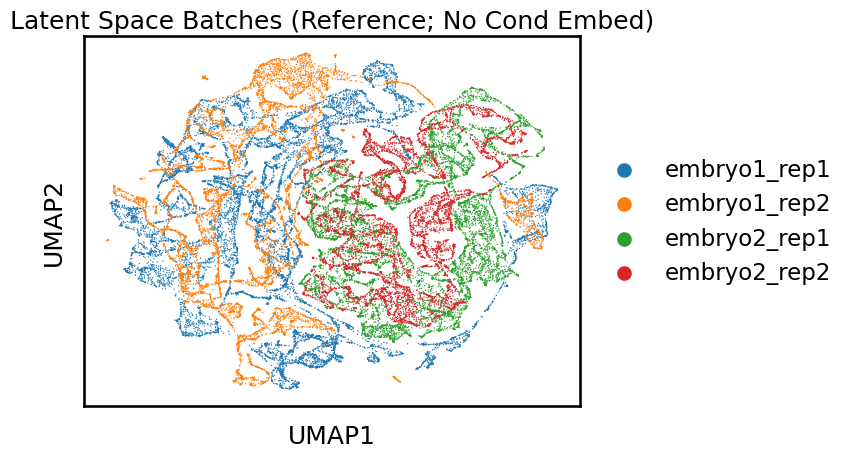

In [48]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 title="Latent Space Batches (Reference; No Cond Embed)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_batches_reference_no_cond_embed.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


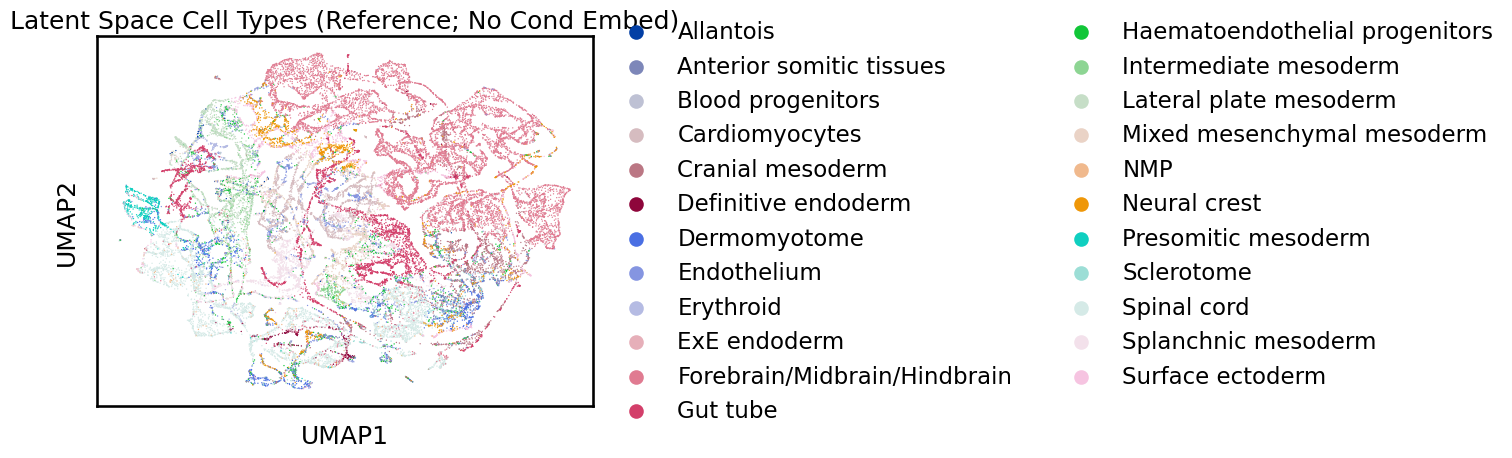

In [49]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 title="Latent Space Cell Types (Reference; No Cond Embed)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference_no_cond_embed.png",
            bbox_inches="tight")

##### 3.4.1.4 Analyze Batch Correction Metrics

In [ ]:
batch_correction_metrics_reference = {}

batch_correction_metrics_reference["graph_connectivity"] = scib.me.graph_connectivity(
    model.adata,
    label_key=cell_type_key)

batch_correction_metrics_reference["ilisi_graph"] = scib.me.ilisi_graph(
    model.adata,
    batch_key=condition_key,
    type_="embed",
    use_rep=latent_key)

batch_correction_metrics_reference["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_reference)

##### 3.4.1.5 Analyze Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
adata_cond_embed = ad.AnnData(cond_embed)
adata_cond_embed.obs["batch"] = model.adata.obs["batch"].unique()

In [ ]:
sc.pp.neighbors(adata_cond_embed)
sc.tl.umap(adata_cond_embed)
fig = sc.pl.umap(adata_cond_embed,
                 color=[condition_key],
                 size=200,
                 title="Conditional Embeddings with Decoder Integrated Batches: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/cond_embed_autotalker_batches_integrated_decoder.png",
            bbox_inches="tight")

#### 3.4.2 Query

##### 3.4.2.1 Initialize, Train & Save Model

In [57]:
# Load model trained on reference data for transfer learning with query data
# Freeze all weights except for conditional weights
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_no_cond_embed",
                        adata=adata_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names",
                        unfreeze_all_weights=True)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 0, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 0, n_addon_input: 0, n_output: 702


In [58]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 8467
Number of validation nodes: 941
Number of training edges: 58005
Number of validation edges: 6445

--- MODEL TRAINING ---
Epoch 1/10 |██------------------| 10.0% val_auroc_score: 0.9644; val_auprc_score: 0.9362; val_best_acc_score: 0.8625; val_best_f1_score: 0.8790; train_kl_reg_loss: 0.0219; train_edge_recon_loss: 0.0192; train_gene_expr_recon_loss: 0.5117; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.5529; train_optim_loss: 0.5529; val_kl_reg_loss: 0.0199; val_edge_recon_loss: 0.0111; val_gene_expr_recon_loss: 0.4973; val_group_lasso_reg_loss: 0.0000; val_global_loss: 0.5283; val_optim_loss: 0.5283
Epoch 2/10 |████----------------| 20.0% val_auroc_score: 0.9695; val_auprc_score: 0.9449; val_best_acc_score: 0.8732; val_best_f1_score: 0.8873; train_kl_reg_loss: 0.0211; train_edge_recon_loss: 0.0188; train_gene_expr_recon_loss: 0.5071; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.5470; train_optim_loss: 0

In [59]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_query_no_cond_embed",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.4.2.2 Load Model

In [60]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_query_no_cond_embed",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 0, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 0, n_addon_input: 0, n_output: 702


##### 3.4.1.3 Analyze Latent Space

In [61]:
adata_reference_query.uns[gp_names_key] = adata_reference.uns[gp_names_key]

adata_reference_query.obsm["autotalker_latent"] = model.get_latent_representation(
    adata=adata_reference_query,
    condition_key="batch")

In [62]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_reference_query, use_rep=latent_key)
sc.tl.umap(adata_reference_query)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


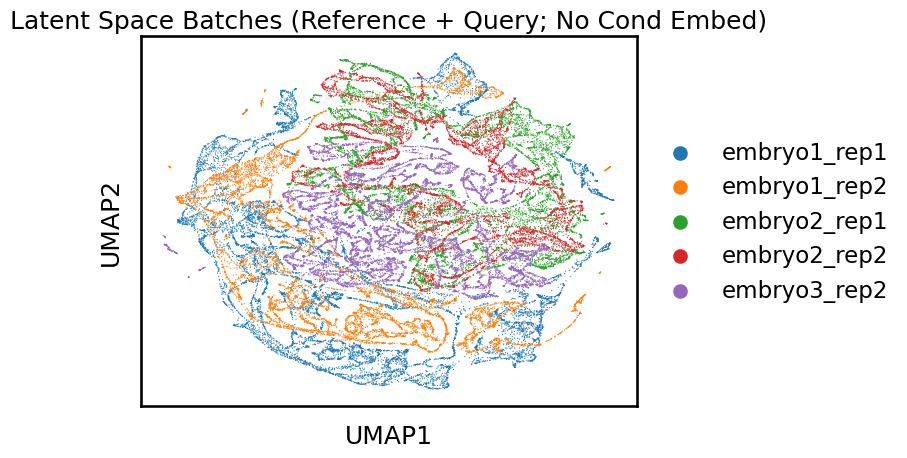

In [63]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[condition_key],
                 title="Latent Space Batches (Reference + Query; No Cond Embed)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_batches_reference_query_no_cond_embed.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


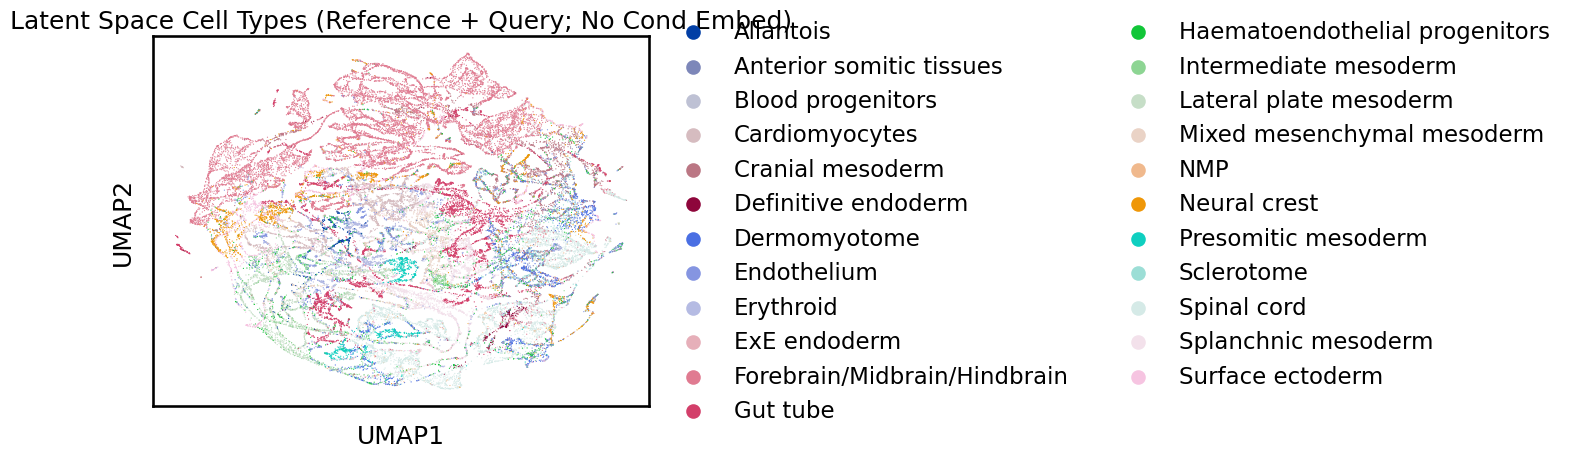

In [64]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[cell_type_key],
                 title="Latent Space Cell Types (Reference + Query; No Cond Embed)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference_query_no_cond_embed.png",
            bbox_inches="tight")

##### 3.4.2.4 Analyze Batch Correction Metrics

In [ ]:
batch_correction_metrics_reference_query_integrated = {}

batch_correction_metrics_reference_query_integrated["graph_connectivity"] = scib.me.graph_connectivity(
    adata_reference_query,
    label_key=cell_type_key)

batch_correction_metrics_reference_query_integrated["ilisi_graph"] = scib.me.ilisi_graph(
    adata_reference_query,
    batch_key=condition_key,
    type_="embed",
    use_rep=latent_key)

batch_correction_metrics_reference_query_integrated["silhouette_batch"] = scib.me.silhouette_batch(
    adata_reference_query,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_reference_query_integrated)

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
adata_cond_embed = ad.AnnData(cond_embed)
adata_cond_embed.obs["batch"] = model.adata.obs["batch"].unique()

In [ ]:
sc.pp.neighbors(adata_cond_embed)
sc.tl.umap(adata_cond_embed)
fig = sc.pl.umap(adata_cond_embed,
                 color=[condition_key],
                 size=200,
                 title="Conditional Embeddings with Decoder Integrated Batches: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/cond_embed_autotalker_batches_integrated_decoder.png",
            bbox_inches="tight")

### 3.4 Autotalker Model With Query-to-Reference Mapping

#### 3.4.1 Reference

##### 3.4.1.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = Autotalker(adata_reference,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=3,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_integrated",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.4.1.2 Load Model

In [ ]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_integrated",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

##### 3.4.1.3 Analyze Latent Space

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 title="Latent Space Reference: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_batches_reference_integrated.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 title="Latent Space with Cell Types: Autotalker (Reference)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_cell_types_reference_integrated.png",
            bbox_inches="tight")

##### 3.4.1.4 Analyze Batch Correction Metrics

In [ ]:
batch_correction_metrics_reference = {}

batch_correction_metrics_reference["graph_connectivity"] = scib.me.graph_connectivity(
    model.adata,
    label_key=cell_type_key)

batch_correction_metrics_reference["ilisi_graph"] = scib.me.ilisi_graph(
    model.adata,
    batch_key=condition_key,
    type_="embed",
    use_rep=latent_key)

batch_correction_metrics_reference["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_reference)

##### 3.4.1.5 Analyze Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
adata_cond_embed = ad.AnnData(cond_embed)
adata_cond_embed.obs["batch"] = model.adata.obs["batch"].unique()

In [ ]:
sc.pp.neighbors(adata_cond_embed)
sc.tl.umap(adata_cond_embed)
fig = sc.pl.umap(adata_cond_embed,
                 color=[condition_key],
                 size=200,
                 title="Conditional Embeddings with Decoder Integrated Batches: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/cond_embed_autotalker_batches_integrated_decoder.png",
            bbox_inches="tight")

#### 3.4.2 Query

##### 3.4.2.1 Initialize, Train & Save Model

In [ ]:
# Load model trained on reference data for transfer learning with query data
# Freeze all weights except for conditional weights
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_integrated",
                        adata=adata_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names",
                        unfreeze_all_weights=False,
                        unfreeze_cond_embed_weights=True)

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_query_integrated",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.4.2.2 Load Model

In [ ]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_query_integrated",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

##### 3.4.1.3 Analyze Latent Space

In [ ]:
adata_reference_query.uns[gp_names_key] = adata_reference.uns[gp_names_key]

adata_reference_query.obsm["autotalker_latent"] = model.get_latent_representation(
    adata=adata_reference_query,
    condition_key="batch")

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_reference_query, use_rep=latent_key)
sc.tl.umap(adata_reference_query)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[condition_key],
                 title="Latent Space Reference Query Mapping: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_batches_reference_query_integrated.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[cell_type_key],
                 title="Latent Space with Cell Types: Autotalker (Reference)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_cell_types_reference_query_integrated.png",
            bbox_inches="tight")

##### 3.4.2.4 Analyze Batch Correction Metrics

In [ ]:
batch_correction_metrics_reference_query_integrated = {}

batch_correction_metrics_reference_query_integrated["graph_connectivity"] = scib.me.graph_connectivity(
    adata_reference_query,
    label_key=cell_type_key)

batch_correction_metrics_reference_query_integrated["ilisi_graph"] = scib.me.ilisi_graph(
    adata_reference_query,
    batch_key=condition_key,
    type_="embed",
    use_rep=latent_key)

batch_correction_metrics_reference_query_integrated["silhouette_batch"] = scib.me.silhouette_batch(
    adata_reference_query,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_reference_query_integrated)

##### 3.4.1.4 Analyze Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
adata_cond_embed = ad.AnnData(cond_embed)
adata_cond_embed.obs["batch"] = adata_reference_query.obs["batch"].unique()

In [ ]:
sc.pp.neighbors(adata_cond_embed)
sc.tl.umap(adata_cond_embed)
fig = sc.pl.umap(adata_cond_embed,
                 color=[condition_key],
                 size=200,
                 title="Conditional Embeddings with Decoder Integrated Batches: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/cond_embed_autotalker_batches_integrated_decoder.png",
            bbox_inches="tight")

In [ ]:
adata_complete = adata_complete[adata_complete.obs["batch"] != "embryo3_rep1"]

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_complete, use_rep=latent_key, key_added=latent_key)
sc.tl.umap(adata_complete, neighbors_key=latent_key)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_complete,
                 color=[condition_key],
                 title="Latent Space with Decoder Integrated Batches: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_batches_integrated_decoder.png",
            bbox_inches="tight")

In [ ]:
scib.me.silhouette_batch(adata=adata_one_shot,
                         batch_key=condition_key,
                         label_key=cell_type_key,
                         embed=latent_key)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_one_shot.obs["condition"] = le.fit_transform(adata_one_shot.obs["batch"].values)

cond_embed = model.get_conditional_embeddings()
active_gp_mask = model.model.get_active_gp_mask()
cond_embed_dot_pr = np.array(model.model.graph_decoder.cond_embed_l(torch.tensor(cond_embed, device="cuda:0"))[:, active_gp_mask].cpu().detach())

In [ ]:
adata_one_shot.obsm["autotalker_latent_cond"] = adata_one_shot.obsm["autotalker_latent"] + cond_embed_dot_pr[torch.tensor(adata_one_shot.obs["condition"].values)]

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_one_shot, use_rep="autotalker_latent_cond")
sc.tl.umap(adata_one_shot)

In [ ]:
fig = sc.pl.umap(adata_one_shot,
                 color=[condition_key],
                 title="Latent Space with Decoder Integrated Batches: Autotalker",
                 return_fig=True)

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_one_shot, use_rep=latent_key)
sc.tl.umap(adata_one_shot)

In [ ]:
fig = sc.pl.umap(adata_one_shot,
                 color=[condition_key],
                 title="Latent Space with Decoder Integrated Batches: Autotalker",
                 return_fig=True)